Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'

In [2]:
# Load data downloaded from https://srcole.github.io/100burritos/
import numpy as np
import pandas as pd
pd.options.display.max_columns = 60
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv', parse_dates=['Date'], index_col='Date')

In [3]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [4]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [5]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [6]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [7]:
df.head()

,Burrito,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,California,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,California,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,Carnitas,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,Asada,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-27,California,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 58 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Burrito         421 non-null    object 
 1   Yelp            87 non-null     float64
 2   Google          87 non-null     float64
 3   Chips           26 non-null     object 
 4   Cost            414 non-null    float64
 5   Hunger          418 non-null    float64
 6   Mass (g)        22 non-null     float64
 7   Density (g/mL)  22 non-null     float64
 8   Length          283 non-null    float64
 9   Circum          281 non-null    float64
 10  Volume          281 non-null    float64
 11  Tortilla        421 non-null    float64
 12  Temp            401 non-null    float64
 13  Meat            407 non-null    float64
 14  Fillings        418 non-null    float64
 15  Meat:filling    412 non-null    float64
 16  Uniformity      419 non-null    float64
 17  Salsa           

Gonna drop a few more things here. Google and Yelp columns are mostly null, and it seems we shouldn't be using them anyway, since we're basically trying to predict rating.

I'll also drop Mass and Density, since those have even more NaNs. The rest of the numeric columns seem to have enough values that we can replace their remaining NaNs with the corresponding column means (with SimpleImputer).

Drop Queso since it's 100% null.

All these specific object columns seem intended to be boolean, with NaNs meaning False and x's meaning true. I could let OneHot take care of these, but that would result in doubling those columns for no reason. Let's make sure I'm right and then convert accordingly.

In [9]:
df = df.drop(columns=['Google', 'Yelp','Mass (g)','Density (g/mL)','Queso'])

In [10]:
move_to_end = ['Chips', 'Great']

df = df[[col for col in df if col not in move_to_end] + move_to_end]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 53 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Burrito        421 non-null    object 
 1   Cost           414 non-null    float64
 2   Hunger         418 non-null    float64
 3   Length         283 non-null    float64
 4   Circum         281 non-null    float64
 5   Volume         281 non-null    float64
 6   Tortilla       421 non-null    float64
 7   Temp           401 non-null    float64
 8   Meat           407 non-null    float64
 9   Fillings       418 non-null    float64
 10  Meat:filling   412 non-null    float64
 11  Uniformity     419 non-null    float64
 12  Salsa          396 non-null    float64
 13  Synergy        419 non-null    float64
 14  Wrap           418 non-null    float64
 15  Unreliable     33 non-null     object 
 16  NonSD          7 non-null      object 
 17  Beef           179 non-null    obje

In [11]:
df.loc[:,'Unreliable':'Chips'].nunique(dropna=False)

Unreliable       2
NonSD            3
Beef             3
Pico             3
Guac             3
Cheese           3
Fries            3
Sour cream       3
Pork             3
Chicken          3
Shrimp           3
Fish             3
Rice             3
Beans            3
Lettuce          3
Tomato           3
Bell peper       3
Carrots          2
Cabbage          3
Sauce            3
Salsa.1          3
Cilantro         3
Onion            3
Taquito          3
Pineapple        3
Ham              2
Chile relleno    2
Nopales          2
Lobster          2
Egg              2
Mushroom         2
Bacon            2
Sushi            2
Avocado          2
Corn             3
Zucchini         2
Chips            5
dtype: int64

Sure seems I'm wrong that these are supposed to be bool, but let's clean things up and see what we get.

In [12]:
df.loc[:,'Unreliable':'Chips'] = df.loc[:,'Unreliable':'Chips'].replace({'x':'1',
                                                                         'X':'1',
                                                                         'Yes':'1',
                                                                         'yes':'1',
                                                                         'No':'0',
                                                                         'no':'0',
                                                                         np.NaN:'0'}).astype(int)
df.loc[:,'Unreliable':'Chips'].nunique()

Unreliable       2
NonSD            2
Beef             2
Pico             2
Guac             2
Cheese           2
Fries            2
Sour cream       2
Pork             2
Chicken          2
Shrimp           2
Fish             2
Rice             2
Beans            2
Lettuce          2
Tomato           2
Bell peper       2
Carrots          2
Cabbage          2
Sauce            2
Salsa.1          2
Cilantro         2
Onion            2
Taquito          2
Pineapple        2
Ham              2
Chile relleno    2
Nopales          2
Lobster          2
Egg              2
Mushroom         2
Bacon            2
Sushi            2
Avocado          2
Corn             2
Zucchini         2
Chips            2
dtype: int64

Now that's bool.

What's our baseline?

In [13]:
df['Great'].value_counts(normalize=True)

False    0.567696
True     0.432304
Name: Great, dtype: float64

Baseline accuracy: 0.568. Let's see what we can do.

In [14]:
y = df['Great']
X = df.drop(columns='Great')

In [15]:
train_mask = df.index.year < 2017
val_mask = df.index.year == 2017
test_mask = df.index.year > 2017

y_train, X_train = y[train_mask], X[train_mask]
y_val, X_val = y[val_mask], X[val_mask]
y_test, X_test = y[test_mask], X[test_mask]

assert y_train.shape[0] + y_val.shape[0] + y_test.shape[0] == y.shape[0]

In [16]:
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest

In [17]:
model_log = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(k=10),
    LogisticRegression()
)

In [18]:
model_log.fit(X_train, y_train)

c:\users\benjs\opencv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Burrito'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest()),
                ('logisticregression', LogisticRegression())])

In [19]:
print('--Train Accuracy--')
print(model_log.score(X_train, y_train))

--Train Accuracy--
0.889261744966443


In [20]:
print('--Validation Accuracy--')
print(model_log.score(X_val, y_val))

--Validation Accuracy--
0.8470588235294118


Surprised by this inaccuracy of the validation set, I immediately wondered, since some of those specific object columns had so few positives, if maybe the validation set was small enough that some of them had **no** positives. If so, those should obviously be removed from the training set.

In [21]:
X_val.loc[:,'Unreliable':'Chips'].nunique()

Unreliable       2
NonSD            2
Beef             2
Pico             2
Guac             2
Cheese           2
Fries            2
Sour cream       2
Pork             2
Chicken          1
Shrimp           2
Fish             2
Rice             2
Beans            1
Lettuce          1
Tomato           1
Bell peper       1
Carrots          1
Cabbage          2
Sauce            2
Salsa.1          1
Cilantro         1
Onion            1
Taquito          1
Pineapple        1
Ham              1
Chile relleno    1
Nopales          1
Lobster          1
Egg              1
Mushroom         1
Bacon            1
Sushi            1
Avocado          1
Corn             2
Zucchini         1
Chips            2
dtype: int64

In [22]:
X_val = X_val[X_val.columns[X_val.nunique() > 1]]

In [23]:
X_val.nunique()

Burrito          5
Cost            36
Hunger          14
Length          19
Circum          19
Volume          37
Tortilla        12
Temp             9
Meat            17
Fillings        12
Meat:filling    13
Uniformity      18
Salsa           19
Synergy         20
Wrap            16
Unreliable       2
NonSD            2
Beef             2
Pico             2
Guac             2
Cheese           2
Fries            2
Sour cream       2
Pork             2
Shrimp           2
Fish             2
Rice             2
Cabbage          2
Sauce            2
Corn             2
Chips            2
dtype: int64

Much better. Now let's make sure our Train and Test sets are narrowed to these same columns, and then refit the model. I'm actually going to totally redefine the model so I can play around with the k value.

In [24]:
X_train = X_train[X_val.columns]
X_test = X_test[X_val.columns]

In [25]:
train_accuracies = []
val_accuracies = []
k_range = np.arange(2, 20)

for k in k_range:
    k_test_model = make_pipeline(
        OneHotEncoder(use_cat_names=True),
        SimpleImputer(),
        StandardScaler(),
        SelectKBest(k=k),
        LogisticRegression()
    )
    k_test_model.fit(X_train, y_train)
    
    train_accuracies.append(k_test_model.score(X_train, y_train))
    val_accuracies.append(k_test_model.score(X_val, y_val))

c:\users\benjs\opencv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\users\benjs\opencv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\users\benjs\opencv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\users\benjs\opencv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\users\benjs\opencv\lib\site-packages\category_encoders\utils.py:21: F

In [26]:
import matplotlib.pyplot as plt

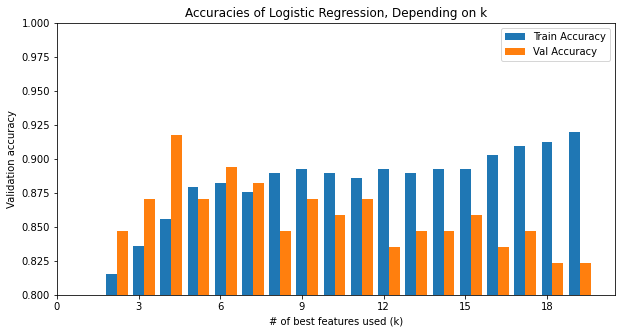

In [27]:
fig, ax = plt.subplots(figsize=[10,5])

w = .4

train_ac = ax.bar(x=k_range, height=train_accuracies, width=w)
val_ac = ax.bar(x=k_range+w, height=val_accuracies, width=w)

ax.legend([train_ac, val_ac], ['Train Accuracy', 'Val Accuracy'])

ax.set_xticks([3*n for n in range(7)])

ax.set_title('Accuracies of Logistic Regression, Depending on k')
ax.set_xlabel('# of best features used (k)')
ax.set_ylabel('Validation accuracy')
ax.set_ylim([.8,1])

plt.show()

Looks like we should use k=6! Validation accuracy is better at k=4, but training accuracy suffers a bit.

In [28]:
model_log = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(k=6),
    LogisticRegression()
)

In [29]:
model_log.fit(X_train, y_train)

c:\users\benjs\opencv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Burrito'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest(k=6)),
                ('logisticregression', LogisticRegression())])

In [30]:
print('--Train Accuracy--')
print(model_log.score(X_train, y_train))

--Train Accuracy--
0.8825503355704698


In [31]:
print('--Validation Accuracy--')
print(model_log.score(X_val, y_val))

--Validation Accuracy--
0.8941176470588236


Now, at last, let us check the accuracy of our test set!

In [32]:
print('--TEST ACCURACY--')
print(model_log.score(X_test, y_test))

--TEST ACCURACY--
0.7368421052631579


What a let down!! I was hoping for at least low 80s! 